### Let's start with downloading the raw data

In [1]:
import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader_functions.download_data import download_raw_data
current_dir = os.getcwd()

In [2]:
### TODO update this section per dataset
dataset_config = {
    'dataset_name': 'calif_houses', # dataset name
    'source': 'kaggle',
    'competition': True,
    'remote_path': 'california-house-prices',
    'files': ['train.csv'],
    'rename_files': ['cf_house_train.csv'],
    'task': 'reg',
    #'target': 'Listed Price', # or 'Total interior livable area'
    'target': 'Total interior livable area',
}

In [3]:
if dataset_config['task'] == 'clf':
    dataset_subfolder = os.path.join('raw', 'classification', dataset_config['dataset_name']) 
elif dataset_config['task'] == 'reg':
    dataset_subfolder = os.path.join('raw', 'regression', dataset_config['dataset_name'])
else:
    raise ValueError(f"Unknown task: {dataset_config['task']}")

# this path needs to be modified based on the location of the notebook
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

if download_raw_data(
    dataset_config=dataset_config,
    download_path=download_path,
    force_download=False,
    remove_unlisted=True,
) is not None:
    print(f"Downloaded {dataset_config['dataset_name']} dataset to {download_path}")

Info: Dataset already downloaded in /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/calif_houses.
Downloaded calif_houses dataset to /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/calif_houses


### Now we need to preprocess the data

In [4]:
from dataloader_functions.load_and_pp_raw_data import _drop_empty_columns, _drop_single_value_columns
from dataloader_functions.utils.data_2_df import read_any_to_df
import pandas as pd

import os
current_dir = os.getcwd()

In [5]:
# TODO: to get the dataset size to a reasonable size, we will downsample the .csv files
import os
import pandas as pd

# Define the path
current_dir = os.getcwd()
download_path = os.path.join(current_dir, '..', '..', 'datasets_files', dataset_subfolder)

# File paths
train_path = os.path.join(download_path, dataset_config['rename_files'][0])

# Load safely, skipping bad lines
train_df = pd.read_csv(train_path, on_bad_lines='skip', engine='python')

# Downsample with fallback if not enough rows
train_sample_size = min(len(train_df), 12000)

train_df = train_df.sample(n=train_sample_size, random_state=42).reset_index(drop=True)

# Save back (overwrite the originals)
train_df.to_csv(train_path, index=False)

print(f"Downsampled {train_path} to {train_sample_size} rows.")


Downsampled /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/calif_houses/cf_house_train.csv to 12000 rows.


In [6]:
dataset_files_df = []

if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for file in dataset_config['rename_files']:

    file_location = os.path.join(download_path, file)

    print(f"Loading {file_location}")

    dataset_files_df.append(read_any_to_df(file_location))

# example of the loaded df data:
pd.set_option('display.max_columns', None)
dataset_files_df[0].head(n=3)

Loading /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/calif_houses/cf_house_train.csv


,Id,Address,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Region,Elementary School,Elementary School Score,Elementary School Distance,Middle School,Middle School Score,Middle School Distance,High School,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,28284,147 Rabbit Foot Trl,355000.0,Amazing custom built home atop the knoll of fi...,SingleFamily,2008.0,"Propane, Forced Air",Central Air,Covered,217800.0,3,2.0,2.0,1920.0,2.0,2.0,California Hot Springs,Hot Springs Elementary School,NaN,3.3,NaN,NaN,NaN,Porterville High School,6.0,26.4,NaN,NaN,NaN,NaN,NaN,Covered,NaN,NaN,2020-04-08,395000.0,NaN,NaN,California Hot Springs,93207,CA
1,21535,6057 Dennison St,725000.0,PRICE ADJUSTMENT TO SELL...Exceptional White P...,Unknown,1929.0,NaN,Central Air,"Detached Carport, Garage - Two Door",NaN,NaN,NaN,NaN,NaN,0.0,0.0,Los Angeles,Montebello Park Elementary School,4.0,0.4,NaN,NaN,NaN,Schurr High School,5.0,1.4,Laminate,NaN,Central Air,Built-In,NaN,"Detached Carport, Garage - Two Door",44559.0,1672.0,2020-04-11,739000.0,NaN,NaN,Los Angeles,90022,CA
2,45860,3424 Pomona St,680000.0,Wonderful hideaway nestled in a small cul-de-s...,SingleFamily,2006.0,Central,Central Air,Garage - Attached,5186.0,3,2.0,2.0,1360.0,2.0,2.0,Los Angeles,Glen Alta Elementary School,5.0,0.5,NaN,NaN,NaN,Woodrow Wilson Senior High School,4.0,1.3,"Carpet, Laminate, Tile",Central,Central Air,NaN,In Garage,Garage - Attached,540459.0,6680.0,2020-10-06,680000.0,2008-04-01,450000.0,Dodgertown,90090,CA


In [7]:
## Run some basic data cleaning

dataset_files_gen_cleaned = []

for df_file in dataset_files_df:
    df_size = df_file.shape
    # 1. Drop columns with more than 50% missing values
    df_file = _drop_empty_columns(df_file, threshold=0.5)
    # 2. Drop columns with only one unique value
    df_file = _drop_single_value_columns(df_file)
    # 3. remove duplicates
    df_file = df_file.drop_duplicates()
    # 4. remove rows with missing target values
    df_file = df_file[df_file[dataset_config['target']].notna()]
    # 5. drop unnamed columns
    df_file = df_file.loc[:, ~df_file.columns.str.contains('^Unnamed')]

    dataset_files_gen_cleaned.append(df_file)

    print(f"Dataframe shape before/afrer cleaning: {df_size} / {df_file.shape}")

Dropped: Index([], dtype='object')
Dataframe shape before/afrer cleaning: (12000, 41) / (11349, 41)


In [8]:
## TODO: Now run custom data cleaning -> remove non-essential columns

cols_to_drop = ['Id', 'Address', # non-informative
                'High School', 'Middle School', 'Elementary School', # too fined grained
                'State', 'Region', # only 2 states and region is redundant to ZIP,
                'Sold Price', 'Listed Price', # way to correlated to target
                'Last Sold On', 'Listed On' # last sold is often empty, listed on is 
    ]

dataset_files_cleaned = []

# assuming for multiple files we still want to drop the same columns
for df_file in dataset_files_gen_cleaned:
    df_size = df_file.shape
    for col in cols_to_drop:
        if col in df_file.columns:
            df_file.drop(col, axis=1, inplace=True)
        else:
            print(f"Column {col} not found in dataframe")

    dataset_files_cleaned.append(df_file)    
    print(f"Dataframe shape before/afrer by-hand cleaning: {df_size} / {df_file.shape}")


Dataframe shape before/afrer by-hand cleaning: (11349, 41) / (11349, 30)


In [9]:
# TODO: some custom data cleaning

import copy 
tmp_df = copy.deepcopy(dataset_files_cleaned)

for df_file in dataset_files_cleaned:
    print(f"Dataframe shape before custom cleaning: {df_file.shape}")
    
    if 'Last Sold On' in df_file.columns:
        # convert to datetime
        df_file['Last Sold On'] = pd.to_datetime(df_file['Last Sold On'], format='%Y-%m-%d')
        # convert to seconds
        df_file['Last Sold On'] = df_file['Last Sold On'].astype('int64') / 1e9

    if 'Listed On' in df_file.columns:
        df_file['Last Sold On'] = pd.to_datetime(df_file['Last Sold On'], format='%Y-%m-%d')
        df_file['Last Sold On'] = df_file['Last Sold On'].astype('int64') / 1e9  # nanoseconds to seconds

    print(f"Dataframe shape after custom clearning: {df_file.shape}")

display(dataset_files_cleaned[0].head(n=3))

dataset_files_by_hand_cleaned = dataset_files_cleaned

dataset_files_cleaned = tmp_df

Dataframe shape before custom cleaning: (11349, 30)
Dataframe shape after custom clearning: (11349, 30)


,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Last Sold Price,City,Zip
0,Amazing custom built home atop the knoll of fi...,SingleFamily,2008.0,"Propane, Forced Air",Central Air,Covered,217800.0,3,2.0,2.0,1920.0,2.0,2.0,NaN,3.3,NaN,NaN,6.0,26.4,NaN,NaN,NaN,NaN,NaN,Covered,NaN,NaN,NaN,California Hot Springs,93207
2,Wonderful hideaway nestled in a small cul-de-s...,SingleFamily,2006.0,Central,Central Air,Garage - Attached,5186.0,3,2.0,2.0,1360.0,2.0,2.0,5.0,0.5,NaN,NaN,4.0,1.3,"Carpet, Laminate, Tile",Central,Central Air,NaN,In Garage,Garage - Attached,540459.0,6680.0,450000.0,Dodgertown,90090
3,1051 Cathedral is a Cape Cod-style cabin nestl...,SingleFamily,1935.0,Fireplace,NaN,On-street,16552.8,1,1.0,1.0,665.0,0.0,0.0,6.0,1.5,NaN,NaN,7.0,2.6,Hardwood,NaN,NaN,"Freezer, Range / Oven, Refrigerator",NaN,On-street,627234.0,7205.0,523000.0,Aptos,95003


### Now it is time to visualize our changes

In [10]:
pd.set_option('display.max_columns', None)

dataset_files_by_hand_cleaned[0].head(n=3)

,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Last Sold Price,City,Zip
0,Amazing custom built home atop the knoll of fi...,SingleFamily,2008.0,"Propane, Forced Air",Central Air,Covered,217800.0,3,2.0,2.0,1920.0,2.0,2.0,NaN,3.3,NaN,NaN,6.0,26.4,NaN,NaN,NaN,NaN,NaN,Covered,NaN,NaN,NaN,California Hot Springs,93207
2,Wonderful hideaway nestled in a small cul-de-s...,SingleFamily,2006.0,Central,Central Air,Garage - Attached,5186.0,3,2.0,2.0,1360.0,2.0,2.0,5.0,0.5,NaN,NaN,4.0,1.3,"Carpet, Laminate, Tile",Central,Central Air,NaN,In Garage,Garage - Attached,540459.0,6680.0,450000.0,Dodgertown,90090
3,1051 Cathedral is a Cape Cod-style cabin nestl...,SingleFamily,1935.0,Fireplace,NaN,On-street,16552.8,1,1.0,1.0,665.0,0.0,0.0,6.0,1.5,NaN,NaN,7.0,2.6,Hardwood,NaN,NaN,"Freezer, Range / Oven, Refrigerator",NaN,On-street,627234.0,7205.0,523000.0,Aptos,95003


Let's figure out which columns should be viewed as categorical / numerical / textual

we can start with a simple heuristic:
1. numerical is everything which
    - keeps most of its character length after non-numeral strip
    - has about the same number of unique values after the strip
    + for the purpose of keeping "semantic information", hand picked columns can be viewed also as non-numerical, that is not the default benchmark approach though

2. categorical is everthing non numerical, which can be then divided into N (where N << Num instances) unique categories

3. textual is everything else

In [11]:
import pandas as pd
import re

def is_mostly_numeric(series, length_threshold=0.5, unique_threshold=0.8):
    """Check if column is mostly numeric after stripping non-numeric chars."""
    stripped = series.astype(str).str.replace(r"[^\d\.\-]", "", regex=True)
    
    original_len = series.astype(str).str.len().replace(0, 1)  # avoid div by zero
    length_ratio = (stripped.str.len() / original_len).mean()

    unique_ratio = stripped.nunique(dropna=False) / max(series.nunique(dropna=False), 1)

    return length_ratio > length_threshold and unique_ratio > unique_threshold

def classify_columns(df, unique_ratio_threshold=None, explicit_nunique_threshold=None):
    """
    Classify dataframe columns into numerical, categorical, textual.
    - Binary categorical (2 unique values) is considered categorical.
    """
    n_rows = len(df)

    # Determine threshold for categorical vs textual
    if explicit_nunique_threshold is not None:
        nunique_threshold = explicit_nunique_threshold
    elif unique_ratio_threshold is not None:
        nunique_threshold = int(unique_ratio_threshold * n_rows)
    else:
        nunique_threshold = int(0.05 * n_rows)  # default 5%

    nunique_threshold = max(10, nunique_threshold)  # safeguard
    print(f"Threshold for categorical vs textual: {nunique_threshold}")

    numerical_cols = []
    categorical_cols = []
    textual_cols = []

    for col in df.columns:
        series = df[col]
        nunique = series.nunique(dropna=False)

        if pd.api.types.is_numeric_dtype(series):
            if nunique <= nunique_threshold:
                categorical_cols.append(col)
            else:
                numerical_cols.append(col)
        
        elif pd.api.types.is_string_dtype(series) or pd.api.types.is_object_dtype(series):
            if is_mostly_numeric(series):
                numerical_cols.append(col)
            else:
                if nunique <= nunique_threshold:
                    categorical_cols.append(col)
                else:
                    textual_cols.append(col)
        else:
            print(f"⚠️ Unhandled column type: '{col}' (dtype={series.dtype})")

    print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
    print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
    print(f"Textual columns ({len(textual_cols)}): {textual_cols}")

    return numerical_cols, categorical_cols, textual_cols

# Example usage:
for df_file in dataset_files_by_hand_cleaned:
    # Ratio-based (5% of rows)
    numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, unique_ratio_threshold=0.05)
    print("")
    # OR explicit value (e.g., anything <= 50 is categorical)
    # numerical_cols, categorical_cols, textual_cols = classify_columns(df_file, explicit_nunique_threshold=50)


Threshold for categorical vs textual: 567
Numerical columns (6): ['Lot', 'Total interior livable area', 'Tax assessed value', 'Annual tax amount', 'Last Sold Price', 'Zip']
Categorical columns (16): ['Type', 'Year built', 'Cooling', 'Bedrooms', 'Bathrooms', 'Full bathrooms', 'Total spaces', 'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'Middle School Score', 'Middle School Distance', 'High School Score', 'High School Distance', 'Heating features', 'Cooling features']
Textual columns (8): ['Summary', 'Heating', 'Parking', 'Flooring', 'Appliances included', 'Laundry features', 'Parking features', 'City']



Now let's just try to visualize the kept features, their example values, and their cat/num/text allocation

In [12]:
summary = []
for col in df_file.columns:
    if col in categorical_cols:
        col_type = "categorical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in textual_cols:
        col_type = "textual"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = int(num_categories)
    elif col in numerical_cols:
        col_type = "numerical"
        num_categories = df_file[col].nunique(dropna=True)
        num_categories_display = '~ ' + str(num_categories) + ' ~'
    else:
        col_type = "unknown"
        num_categories_display = '--'

    example = df_file[col].dropna().iloc[0] if df_file[col].dropna().size > 0 else None
    summary.append({
        'Column Name': col,
        'Example Value': str(example),
        'Type': col_type,
        '# Categories': num_categories_display
    })

summary_df = pd.DataFrame(summary)

# TODO: by hand changes of the type and category count -> e.g. for 'Location':
#    # Post-processing: override the type and category count for 'Location'
#    # summary_df.loc[summary_df['Column Name'] == 'Location', 'Type'] = 'textual'
#    # num_categories = df_file['Location'].nunique(dropna=True)
#    # summary_df.loc[summary_df['Column Name'] == 'Location', '# Categories'] = int(num_categories)

pd.set_option('display.max_rows', None)
display(summary_df)  # Or print(summary_df)

,Column Name,Example Value,Type,# Categories
0,Summary,Amazing custom built home atop the knoll of fi...,textual,11256
1,Type,SingleFamily,categorical,49
2,Year built,2008.0,categorical,141
3,Heating,"Propane, Forced Air",textual,784
4,Cooling,Central Air,categorical,262
5,Parking,Covered,textual,1736
6,Lot,217800.0,numerical,~ 3703 ~
7,Bedrooms,3,categorical,154
8,Bathrooms,2.0,categorical,15
9,Full bathrooms,2.0,categorical,12


#### We also need to make sure that numerical columns are actually numerical :)

In [13]:
import re
import pandas as pd
import copy

from dataloader_functions.load_and_pp_raw_data import clean_numerical_columns

summary_df, dataset_files_by_hand_cleaned = clean_numerical_columns(summary_df, dataset_files_by_hand_cleaned)

pd.set_option('display.max_rows', None)
display(summary_df)


,Column Name,Example Value,Type,# Categories
0,Summary,Amazing custom built home atop the knoll of fi...,textual,11256
1,Type,SingleFamily,categorical,49
2,Year built,2008.0,categorical,141
3,Heating,"Propane, Forced Air",textual,784
4,Cooling,Central Air,categorical,262
5,Parking,Covered,textual,1736
6,Lot,217800.0,numerical,3703
7,Bedrooms,3,categorical,154
8,Bathrooms,2.0,categorical,15
9,Full bathrooms,2.0,categorical,12


### Saving the processed data and loading it back up

In [14]:
import os
import pandas as pd

# Handle rename_files fallback
if dataset_config['rename_files'] is None or len(dataset_config['rename_files']) == 0:
    dataset_config['rename_files'] = dataset_config['files']

for i, df_file in enumerate(dataset_files_by_hand_cleaned):
    df_with_meta = df_file.copy()

    # Get corresponding file name
    file_name = dataset_config['rename_files'][i]
    file_base = os.path.splitext(file_name)[0]

    # Try assigning multi-index header from summary
    try:
        df_with_meta.columns = pd.MultiIndex.from_frame(
            summary_df[['Column Name', 'Type', '# Categories']]
        )
        local_summary = summary_df.copy()
    except ValueError:
        local_summary = summary_df.copy()
        if dataset_config['target'] in local_summary['Column Name'].values:
            local_summary = local_summary[local_summary['Column Name'] != dataset_config['target']]
            df_with_meta.columns = pd.MultiIndex.from_frame(
                local_summary[['Column Name', 'Type', '# Categories']]
            )
        else:
            raise

    # Construct and save everything together
    output_filename = f"{dataset_config['dataset_name']}_processed.pkl"
    output_path = os.path.join(download_path, output_filename)

    if os.path.exists(output_path):
        print(f"File {output_path} already exists. Skipping save.")
        continue

    save_bundle = {
        'data': df_with_meta,
        'summary': local_summary,
        'config': dataset_config
    }

    pd.to_pickle(save_bundle, output_path)
    print(f"Saved: {output_path}")


File /media/martin/martin_work/TabAdap_Project/datasets_notebooks/regression/../../datasets_files/raw/regression/calif_houses/calif_houses_processed.pkl already exists. Skipping save.


In [15]:
import os
import pandas as pd

import sys
import os
# to reach the dataloader_functions module
module_path = os.path.abspath(os.path.join( "..", "..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from configs.dataset_configs import get_a_dataset_dict

print(dataset_config['dataset_name'])

loaded_dataset_config = get_a_dataset_dict(dataset_config['dataset_name'])

file_base = loaded_dataset_config['name']
processed_filename = f"{file_base}_processed.pkl"
processed_path = os.path.join(download_path, processed_filename)

# Load the bundled dictionary (data + summary + config)
bundle = pd.read_pickle(processed_path)

# Extract components
loaded_df = bundle['data']
summary_df = bundle['summary']
loaded_config = bundle['config']

print(f"\n=== {file_base.upper()} ===")
print(f"Loaded config keys: {list(loaded_config.keys())}")

# Show metadata
meta_df = pd.DataFrame(loaded_df.columns.tolist(), columns=['Column Name', 'Type', '# Categories'])
display(meta_df)

# Flatten for modeling
loaded_df.columns = loaded_df.columns.get_level_values(0)
display(loaded_df.head(n=3))


calif_houses

=== CALIF_HOUSES ===
Loaded config keys: ['dataset_name', 'source', 'competition', 'remote_path', 'files', 'rename_files', 'task', 'target']


,Column Name,Type,# Categories
0,Summary,textual,11256
1,Type,categorical,49
2,Year built,categorical,141
3,Heating,textual,784
4,Cooling,categorical,262
5,Parking,textual,1736
6,Lot,numerical,3703
7,Bedrooms,categorical,154
8,Bathrooms,categorical,15
9,Full bathrooms,categorical,12


Column Name,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Tax assessed value,Annual tax amount,Last Sold Price,City,Zip
0,Fixer with a lot of potential! Wonderful neig...,SingleFamily,1953.0,Other,NaN,"Garage, Garage - Attached, Covered",5658.0,3,2.0,1.0,1131.0,2.0,2.0,7.0,0.2,5.0,1.4,6.0,1.7,Hardwood,Other,NaN,NaN,NaN,"Garage, Garage - Attached, Covered",63314.0,809.0,700000.0,Santa Clara,95050.0
1,"68 W Summit Dr, Emerald Hills, CA 94062 is a s...",SingleFamily,1947.0,Central Forced Air - Gas,NaN,"Underground/Basement, Garage - Attached",7257.0,3,2.0,2.0,1810.0,0.0,0.0,6.0,1.1,NaN,NaN,6.0,2.9,NaN,"Forced air, Gas",NaN,NaN,In Utility Room,"Underground/Basement, Garage - Attached",611324.0,8345.0,435000.0,Redwood City,94062.0
2,Sunrise to sunset you will adore this elegant ...,Townhouse,1984.0,"Fireplace, Central Forced Air",NaN,"Garage, Garage - Attached, Covered",2117.0,3,3.0,2.0,1759.0,1.0,1.0,2.0,0.5,5.0,0.5,7.0,1.6,"Laminate, Carpet",Forced air,NaN,"Dishwasher, Garbage disposal, Microwave",Inside,"Garage, Garage - Attached, Covered",535000.0,6114.0,NaN,Morgan Hill,95037.0


### Bonus insights (Regression)

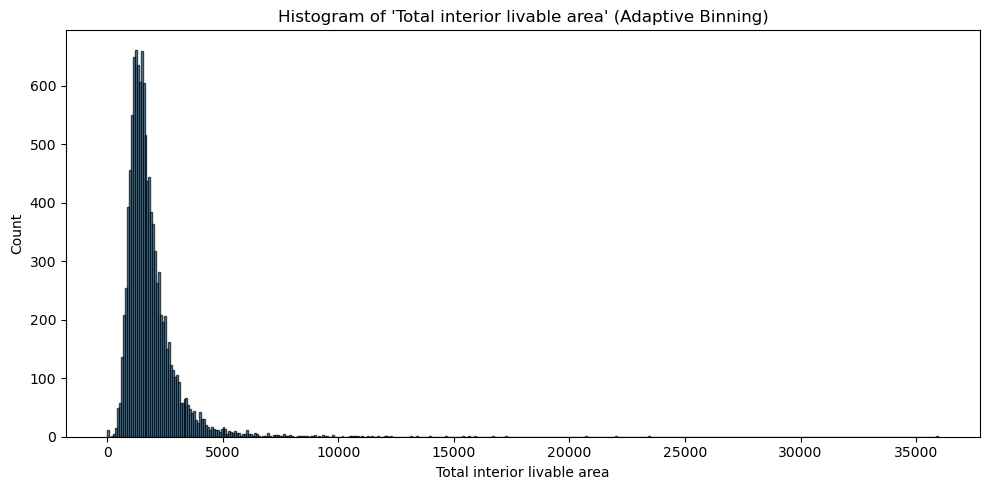

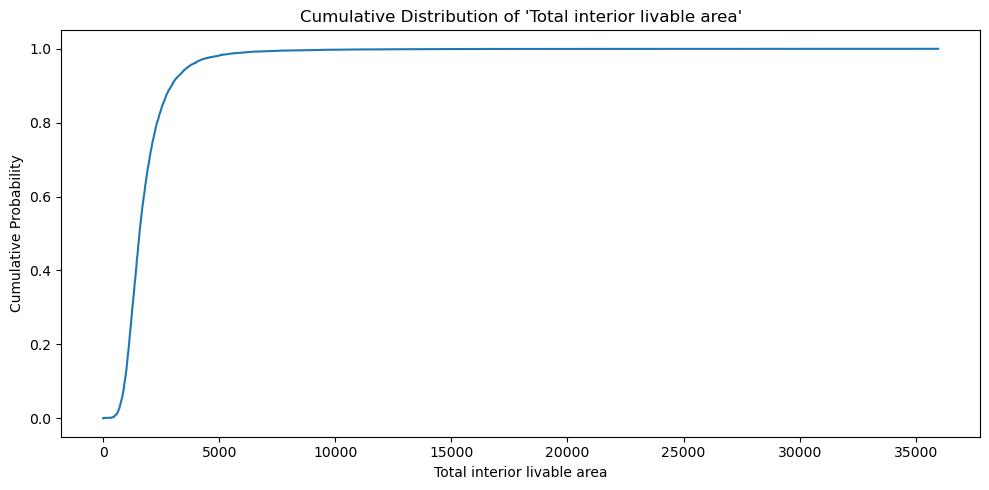

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get target series
target_series = loaded_df[dataset_config['target']]

# 1️⃣ Histogram with Freedman-Diaconis rule for binning
q25, q75 = np.percentile(target_series, [25, 75])
iqr = q75 - q25
bin_width = 2 * iqr * len(target_series) ** (-1/3)
bin_count = int((target_series.max() - target_series.min()) / bin_width)
bin_count = max(10, bin_count)  # Ensure reasonable minimum bin count

plt.figure(figsize=(10, 5))
plt.hist(target_series, bins=bin_count, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of '{dataset_config['target']}' (Adaptive Binning)")
plt.xlabel(dataset_config['target'])
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 2️⃣ Cumulative Distribution Function (CDF)
target_sorted = target_series.sort_values()
cdf = np.arange(len(target_sorted)) / len(target_sorted)

plt.figure(figsize=(10, 5))
plt.plot(target_sorted, cdf, color='tab:blue')
plt.title(f"Cumulative Distribution of '{dataset_config['target']}'")
plt.xlabel(dataset_config['target'])
plt.ylabel('Cumulative Probability')
plt.tight_layout()
plt.show()

